<a href="https://colab.research.google.com/github/pds2021/capstone-group_2/blob/Projekt_PDS/1_Projekt_L%C3%B6sungen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Projekt zur iWildCam 2020 Competition

Camera Traps und Wildkameras können automatisch eine große Menge an Bilddaten sammeln und speichern. Diese werden von Biologen weltweit genutzt, um die Artenvielfalt und Populationsdichte von Tierarten zu überwachen.

Die Aufgabe ist es, ein Deep-Learning-Modell zur automatischen Erkennung und Klassifizierung von Tierarten mittels Image Classification in Kombination mit Object Detection (unter Verwendung von Bounding Boxes) zu entwickeln.

In diesem Notebook werden die zur Verfügung gestellten Daten der [iWildCam 2020 Competition](https://www.kaggle.com/c/iwildcam-2020-fgvc7/data) untersucht. 
Dabei werden speziell die Daten aus den JSON Dateien "train_annotations" und "megadetector_results" näher beleuchtet, die Daten analysiert sowie ein paar Statistiken betrachtet. Anschließend werden die für das RetinaNet benötigten JSON Dateien erstellt.


# Erläuterung der Umsetzung

Zur Bearbeitung der Projektaufgabe wurde das RetinaNet herangezogen. Für die Detection in den Bildern wurde der MegaDetector-V4 angewendet. Aufgrund der großen Datenmenge wurde sich im Team dazu entschieden, dass Projekt in Kaggle-Notebooks anstatt in Colab-Notebooks durchzuführen. Dies ersparte das Export und Import Problem, welches durch die große Datenmenge von 110GB Bilder entstanden wäre. Jedoch ist nach einiger Zeit aufgefallen, dass die Kaggle-Notebooks auf eine Laufzeit von 9h begrenzt sind und man in der Woche maximal 43h GPU-Rechenleistung zur Verfügung hat. Da jedoch die Nutzung des Detectors und des RetinaNets für die 62.870 Abgabe-Bilder in diesen Zeitspannen mit gegebener Rechenleistung für uns nicht möglich war, haben wir eine alternative Lösung erarbeitet. Diese enthält den Detector und das RetinaNet nur für einen kleinen Datenausschnitt. Für die Abgabe wurde ein herkömmlicher Klassifikator trainiert und auf die Abgabe-Bilder angewendet. Abschließend wurde der herkömmliche Klassifikator noch in Form einer App zur Nutzung im Alltag zur Verfügung gestellt.

Inhalt der Abgabe sind folgende Dateien:

1. Dieses Notebook
2. [MegaDetector_V4](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/MegaDetector_V4.ipynb)
3. [RetinaNet](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/3_RetinaNet.ipynb)
4. [Herkömmlicher Klassifikator](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/resnetClassifier.ipynb)
5. [Erste Kaggle Abgabe CSV](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/submission1.csv)
6. [Zweite Kaggle Abgabe CSV](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/submission2.csv)
7. [QuellCode zur App](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/wildcam_app.ipynb)
8. [Requirements.txt für App](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/requirements.txt)
9. [MegaDetector_V4 BeispielErgebnis](https://github.com/pds2021/capstone-group_2/tree/Projekt_PDS/detector)


Bearbeiter:
* Elias, Emanuel
* XXX, Franziska
* XXX, Christoph

Die Ergebnise des Projektes dürfen vom Lehrstuhl frei weiter verwendet werden.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import json
!pip install -Uqq fastai
from fastai import *
from fastai.vision.all import *

import seaborn as sns
import matplotlib.ticker as ticker

Der Pfad führt zu den Daten der iWildCam 2020, die für die Image Classification und Object Detection benötigt werden.

In [ ]:
path = Path('/kaggle/input/iwildcam-2020-fgvc7')

Zuerst werden die beiden JSON Dateien "train_annotations" und "megadetector_results" geladen.

In [ ]:
with open(r'/kaggle/input/iwildcam-2020-fgvc7/iwildcam2020_train_annotations.json') as json_file:
    train_data = json.load(json_file)
with open(r'/kaggle/input/iwildcam-2020-fgvc7/iwildcam2020_megadetector_results.json') as json_file:
    megadet_data = json.load(json_file)

# Train Daten

Anhand der Keys erhält man die in Train beinhalteten Eigenschaften. Enthalten sind Annotation-, Image-, Kategorie- und Informationsdaten.

In [ ]:
train_data.keys()

dict_keys(['annotations', 'images', 'categories', 'info'])

Um die Inhalte in Dataframes auszulesen, werden die Keys einzelnd betrachtet.

In [ ]:
train_annotations = train_data['annotations']
#wegen Namensgebung später hier V2 genannt
train_imagesV2 = train_data['images']
train_categories = train_data['categories']

Aus den Keys der JSON Dateien werden Dataframes für die Images, Annotations und Categories erstellt. Info enthält lediglich eine Beschreibung der Datensatzversion sowie die Contributors und kann somit vernachlässigt werden.

Der Datensatz "train_annotations" enthält zu jedem Trainingsbild die Informationen Image ID, ID, Anzahl und Kategorie ID.

In [ ]:
train_annotations = pd.DataFrame.from_dict(train_annotations)
train_annotations.head()

,count,image_id,id,category_id
0,1,96b00332-21bc-11ea-a13a-137349068a90,a292dd3c-21bc-11ea-a13a-137349068a90,73
1,1,879d74d8-21bc-11ea-a13a-137349068a90,a0afcfc0-21bc-11ea-a13a-137349068a90,4
2,1,9017f7aa-21bc-11ea-a13a-137349068a90,a306e9c0-21bc-11ea-a13a-137349068a90,227
3,1,90d93c58-21bc-11ea-a13a-137349068a90,9eed94c4-21bc-11ea-a13a-137349068a90,250
4,1,887cd0ec-21bc-11ea-a13a-137349068a90,a2a4dd7a-21bc-11ea-a13a-137349068a90,2


Der Datensatz "train_images" beinhaltet die Bildinformationen Image ID, Seq_num_frames, Location, Datum, frame_num, seq_id, Breite und Höhe der Bilder sowie den Imagenamen.

In [ ]:
train_images = pd.DataFrame.from_dict(train_imagesV2)
train_images = train_images.rename(columns = {"id":"image_id","file_name":"image_name"})
train_images.head()

,seq_num_frames,location,datetime,image_id,frame_num,seq_id,width,height,image_name
0,1,267,2013-08-08 11:45:00.000,96b00332-21bc-11ea-a13a-137349068a90,1,96b004ea-21bc-11ea-a13a-137349068a90,1795,1222,96b00332-21bc-11ea-a13a-137349068a90.jpg
1,1,264,2013-08-01 22:31:00.000,879d74d8-21bc-11ea-a13a-137349068a90,1,879d7654-21bc-11ea-a13a-137349068a90,2739,1772,879d74d8-21bc-11ea-a13a-137349068a90.jpg
2,1,45,2013-04-17 11:15:00.000,9017f7aa-21bc-11ea-a13a-137349068a90,1,9017f8cc-21bc-11ea-a13a-137349068a90,1891,1222,9017f7aa-21bc-11ea-a13a-137349068a90.jpg
3,1,45,2013-04-23 08:26:00.000,90d93c58-21bc-11ea-a13a-137349068a90,1,90d93e38-21bc-11ea-a13a-137349068a90,1795,1222,90d93c58-21bc-11ea-a13a-137349068a90.jpg
4,1,45,2013-04-24 13:51:00.000,887cd0ec-21bc-11ea-a13a-137349068a90,1,887cd29a-21bc-11ea-a13a-137349068a90,1812,1196,887cd0ec-21bc-11ea-a13a-137349068a90.jpg


In "train_categories" sind die Beschreibungen der 267 Kategorien mit der zugehörigen Bezeichnung (Name, ID) und der Anzahl vorhandener Bilder enthalten. Neben den Tierarten, Menschen und leeren Bildern gibt es auch die Klassen *start*, *end* und *misfire*, welche Bilder für Kamera-Start/Ende und Auslösefehler enthalten.

In [ ]:
train_categories = pd.DataFrame.from_dict(train_categories)
train_categories = train_categories.rename(columns = {"id":"category_id","name":"category_name"})
train_categories.head()

,count,category_id,category_name
0,78981,0,empty
1,6355,2,tayassu pecari
2,5833,3,dasyprocta punctata
3,619,4,cuniculus paca
4,4453,6,puma concolor


# Train Set Statistik

Der Datensatz "train_annotations" enthält Informationen zu 217.959 Bildern.
Die Anzahl der Bilder in "train_images" stimmt mit der Anzahl der Bilder in "train_annotations" überein.

In [ ]:
train_annotations.shape #(217959, 4)

(217959, 4)

In [ ]:
train_images.shape #(217959, 9)

(217959, 9)

Die Summe der gezählten Bilder aus "train_categories" stimmt leider nicht mit der Anzahl der Bilder in "train_annotations" und "train_images" überein.

In [ ]:
train_categories['count'].sum() #273.987

273987

Dies fällt zum Beispiel bei der Klasse *human* auf:

In [ ]:
human_anno = train_annotations[train_annotations.category_id.eq(75)]
human_anno #0

,count,image_id,id,category_id


In [ ]:
human_cat = train_categories[train_categories.category_id.eq(75)]
human_cat #33.313

,count,category_id,category_name
36,33313,75,human


Die Datensets enthalten eine unterschiedliche Anzahl an Bildern pro Klasse.

In [ ]:
vergleich = train_annotations[['count','category_id']].groupby(['category_id']).count().reset_index()[['category_id', 'count']]
vergleich['count'] = vergleich['count'] - train_categories['count']
vergleich.head()

,category_id,count
0,0,-4764.0
1,2,-85.0
2,3,0.0
3,4,-481.0
4,6,-85.0


Die Klasse mit den meisten Bildern laut "train_categories" ist *empty*, gefolgt von *human*.

In [ ]:
sort_cat =train_categories[['count','category_name']].sort_values(by=['count'], ascending=False)
sort_cat.head()

,count,category_name
0,78981,empty
36,33313,human
188,16713,meleagris ocellata
189,12908,crax rubra
146,9052,cephalophus nigrifrons


Elf Klassen enthalten laut "train_categories" gar keine Bilder im Trainingsset.

In [ ]:
train_categories[train_categories['count'].eq(0)].shape

(11, 3)

Das Diagramm zeigt die Verteilung der Bilder (TOP 20) nach Kategorie aus dem Datensatz "train_categories":

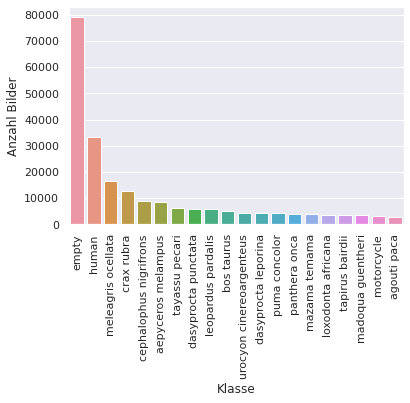

In [ ]:
sns.set_theme(style="darkgrid")

ax2 =sns.barplot(x = 'category_name', y = 'count', data = sort_cat[:20])
ax2.set(xlabel='Klasse', ylabel='Anzahl Bilder')
plt.xticks(rotation='vertical')
plt.show()

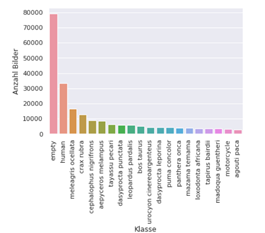

Anzahl der Tiere, die sich auf einem Bild befinden, absteigend sortiert:

In [ ]:
counts_per_image = train_annotations.groupby(by=['image_id']).sum().reset_index()[['image_id', 'count']].sort_values(by=['count'], ascending=False)

TOP 5 (MOST): Es gibt ein Bild, auf dem 80 Tiere zu sehen sind. Es handelt sich um die Klasse *bos taurus* (Hausrind).

In [ ]:
counts_per_image.head()

,image_id,count
130497,91d0f146-21bc-11ea-a13a-137349068a90,80
190827,97062316-21bc-11ea-a13a-137349068a90,75
42664,8a28c004-21bc-11ea-a13a-137349068a90,75
39846,89eab214-21bc-11ea-a13a-137349068a90,75
216092,9926a95e-21bc-11ea-a13a-137349068a90,70


In [ ]:
train_annotations[train_annotations['count'].eq(80)]

,count,image_id,id,category_id
29183,80,91d0f146-21bc-11ea-a13a-137349068a90,a196bd68-21bc-11ea-a13a-137349068a90,71


In [ ]:
train_categories[train_categories['category_id'].eq(71)]

,count,category_id,category_name
32,5118,71,bos taurus


TOP 5 (LEAST): Eine Anzahl von -1 deutet möglicherweise auf keine Tiere hin.

In [ ]:
counts_per_image.tail(5)

,image_id,count
75105,8d028ab2-21bc-11ea-a13a-137349068a90,-1
75101,8d0274fa-21bc-11ea-a13a-137349068a90,-1
156729,9415a4e2-21bc-11ea-a13a-137349068a90,-1
175047,959f6226-21bc-11ea-a13a-137349068a90,-1
161439,947c57c8-21bc-11ea-a13a-137349068a90,-1


Verteilung der Anzahl der Tiere pro Bild: Der Großteil der Bilder enthält ein oder kein Tier.

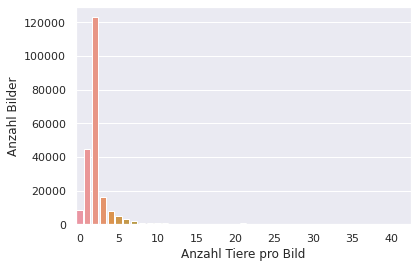

In [ ]:
sns.set_theme(style="darkgrid")

ax = sns.countplot(x="count", data=counts_per_image)
ax.set(xlabel='Anzahl Tiere pro Bild', ylabel='Anzahl Bilder')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

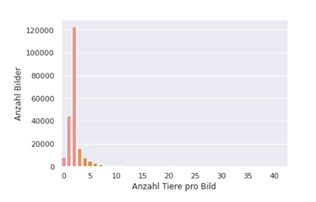

# Anpassen der Daten

Aufgrund der großen Datenmenge und somit sehr langen Ausführzeiten, welche die Kaggle-Executiontime überschreiten würden, sowie der unausgewogenen Verteilung der Bilder pro Klasse werden im Folgenden die Klassengrößen bearbeitet. 
Allgemein kann Undersampling als das Entfernen einiger Beobachtungen der Mehrheitsklasse definiert werden. Ein Nachteil ist jedoch, dass Informationen entfernt werden, die möglicherweise wertvoll sind. Dies kann zwar zu Underfitting und einer schlechten Generalisierung auf den Testsatz führen, jedoch sind wir durch die Kaggle-Executiontime und die Projektdauer beschränkt.

Klassen, die mehr als 1000 Bilder enthalten, werden auf 1000 Bilder gekürzt und es werden nur Klassen beachtet, die mehr als 100 Bilder enthalten.
Zum Iterieren wird "categoryList" genutzt. Es wird auf Anzahl der Bilder untersucht, entsprechend aussortiert und gekürzt.


In [ ]:
categoryList = train_categories["category_id"].values.tolist()
#categoryList

In [ ]:
imageList = []
for category in categoryList:
    dfTemp = train_annotations.copy()
    quantityImages = dfTemp[(dfTemp.category_id == category)].shape[0]
    if quantityImages > 1000:
        #print(str(category) + " " + str(quantityImages))
        imageList = imageList + dfTemp[(dfTemp.category_id == category)][:1000].values.tolist()
    elif quantityImages > 100:
        #print(str(category) + " " + str(quantityImages))
        imageList = imageList + dfTemp[(dfTemp.category_id == category)].values.tolist()

Der neue Datensatz enthält nur die Bilder, die wir für den weiteren Projektverlauf benutzen. Es ersetzt den Datensatz "train_annotations". Er enthält 48.994 Einträge.

In [ ]:
columns = [ 'counter', 'image_id', 'id', 'category_id']
dfNew = pd.DataFrame(imageList, columns=columns)
dfNew.tail()

,counter,image_id,id,category_id
48989,1,87cf48aa-21bc-11ea-a13a-137349068a90,a2a832cc-21bc-11ea-a13a-137349068a90,568
48990,1,908abdbc-21bc-11ea-a13a-137349068a90,a0021934-21bc-11ea-a13a-137349068a90,568
48991,1,8c1c80da-21bc-11ea-a13a-137349068a90,9f8980fa-21bc-11ea-a13a-137349068a90,568
48992,1,86dce0f6-21bc-11ea-a13a-137349068a90,a0647c64-21bc-11ea-a13a-137349068a90,568
48993,1,95fe0308-21bc-11ea-a13a-137349068a90,9fe6ad8e-21bc-11ea-a13a-137349068a90,568


In [ ]:
dfNew.shape

(48994, 4)

Neue Verteilung der Bildanzahl pro Klasse:

In [ ]:
dfNew.groupby('category_id').count()

,counter,image_id,id
category_id,,,
0,1000,1000,1000
2,1000,1000,1000
3,1000,1000,1000
4,138,138,138
6,1000,1000,1000
...,...,...,...
561,130,130,130
565,120,120,120
566,380,380,380


In [ ]:
dfNew_plot = dfNew[['counter','category_id']].groupby(['category_id']).count().reset_index()[['category_id', 'counter']]
dfNew_plot = pd.merge(dfNew_plot, train_categories, on=["category_id"])

Anzahl der Bilder pro Kategorie(TOP 20) für neuen Datensatz:

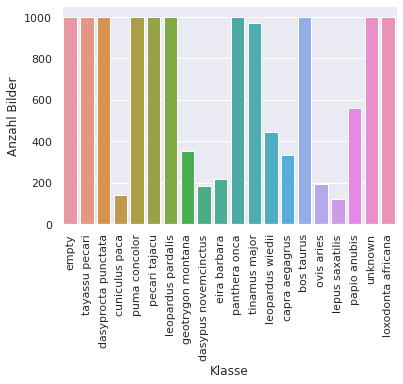

In [ ]:
sns.set_theme(style="darkgrid")

ax2 =sns.barplot(x = 'category_name', y = 'counter', data = dfNew_plot[:20])
ax2.set(xlabel='Klasse', ylabel='Anzahl Bilder')
plt.xticks(rotation='vertical')
plt.show()

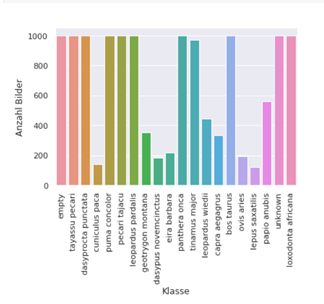

# Detector Daten

Im Datendatz des Megadetectors sind Detections für die Kategorie *human* und *animal* enthalten. Der Datensatz umfasst sowohl Trainings- als auch Testbilder.
Mit den Daten des Megadetectors erhält man für jedes entdeckte Tier einen Eintrag im Dataframe. Dieser enthält neben der Image ID die Detection-Kategorie (Mensch oder Tier), Bounding Box, Konfidenz und die maximale Detection-Konfidenz.

In [ ]:
detec_cat = pd.DataFrame(megadet_data['detection_categories'], index=[0])
detec_cat

,2,1
0,person,animal


In [ ]:
images = megadet_data['images']
detec_images = pd.json_normalize(images, record_path="detections",meta=['id','max_detection_conf'])
detec_images = detec_images.rename(columns = {"id":"image_id","category":"detection_category"})
detec_images.head()

,detection_category,bbox,conf,image_id,max_detection_conf
0,1,"[0.6529, 0.5425, 0.3471, 0.4038]",0.999,905a3c8c-21bc-11ea-a13a-137349068a90,0.999
1,1,"[0.0147, 0.0, 0.9853, 1.0]",0.696,905a3fc0-21bc-11ea-a13a-137349068a90,0.696
2,1,"[0.0, 0.4669, 0.1853, 0.4238]",1.000,905a4416-21bc-11ea-a13a-137349068a90,1.000
3,1,"[0.2406, 0.4672, 0.0309, 0.1105]",0.998,905a4416-21bc-11ea-a13a-137349068a90,1.000
4,1,"[0.5058, 0.4577, 0.06, 0.1043]",0.911,905a4416-21bc-11ea-a13a-137349068a90,1.000


Enhalten sind 320.346 Einträge. Dies kommt zu Stande, da es für jede Detection einen Eintrag gibt. Die Einträge für Testbilder fallen später beim Mergen des Dataframes mit den Traindaten weg.

In [ ]:
detec_images.shape

(320346, 5)

Anzahl Menschen und Tiere auf den Detection Bildern:

In [ ]:
human =detec_images[detec_images["detection_category"]=="2"] 
human.shape #(6732, 5)

(6732, 5)

In [ ]:
animal = detec_images[detec_images["detection_category"]=="1"] 
animal.shape #(313614, 5)

(313614, 5)

Die Konfidenzwahrscheinlichkeit der Detection liegt zwischen 30% und 100%.

In [ ]:
detec_images['conf'].sort_values() 

246882    0.3
85726     0.3
142800    0.3
249507    0.3
170067    0.3
         ... 
172732    1.0
172728    1.0
172727    1.0
172614    1.0
320345    1.0
Name: conf, Length: 320346, dtype: float64

# Zusammenführen der Data Sets

Für die weite Bearbeitung wird ein Dataframe benötigt, das die Informationen aus "train_annotations", "train_images", "train_categories" und "megadetec" enthält. Dafür werden diese gemergt. Die im MegaDetector enhaltenen Detections für Testbilder fallen dabei raus.

In [ ]:
df_train = pd.merge(dfNew, train_images, on=["image_id"])
df_train = pd.merge(df_train, train_categories, on=["category_id"])
df_train.head()

,counter,image_id,id,category_id,seq_num_frames,location,datetime,frame_num,seq_id,width,height,image_name,count,category_name
0,-1,888e07e0-21bc-11ea-a13a-137349068a90,9ab32f72-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-05 10:12:37.000,1,8ede4f1a-21bc-11ea-a13a-137349068a90,1280,1024,888e07e0-21bc-11ea-a13a-137349068a90.jpg,78981,empty
1,-1,8ede4d44-21bc-11ea-a13a-137349068a90,9aafd386-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-05 10:12:38.000,2,8ede4f1a-21bc-11ea-a13a-137349068a90,1280,1024,8ede4d44-21bc-11ea-a13a-137349068a90.jpg,78981,empty
2,-1,868b2ab8-21bc-11ea-a13a-137349068a90,9d80ea64-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-05 10:12:39.000,3,8ede4f1a-21bc-11ea-a13a-137349068a90,1280,1024,868b2ab8-21bc-11ea-a13a-137349068a90.jpg,78981,empty
3,-1,92edf54c-21bc-11ea-a13a-137349068a90,a3609808-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-06 14:04:38.000,1,960b7f9c-21bc-11ea-a13a-137349068a90,1280,1024,92edf54c-21bc-11ea-a13a-137349068a90.jpg,78981,empty
4,-1,885433c6-21bc-11ea-a13a-137349068a90,9ee111a4-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-06 14:04:39.000,2,960b7f9c-21bc-11ea-a13a-137349068a90,1280,1024,885433c6-21bc-11ea-a13a-137349068a90.jpg,78981,empty


In [ ]:
df_train.shape

(48994, 14)

In [ ]:
df = pd.merge(df_train, detec_images, on=['image_id'])
df.head()

,counter,image_id,id,category_id,seq_num_frames,location,datetime,frame_num,seq_id,width,height,image_name,count,category_name,detection_category,bbox,conf,max_detection_conf
0,-1,888e07e0-21bc-11ea-a13a-137349068a90,9ab32f72-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-05 10:12:37.000,1,8ede4f1a-21bc-11ea-a13a-137349068a90,1280,1024,888e07e0-21bc-11ea-a13a-137349068a90.jpg,78981,empty,1,"[0.4978, 0.9242, 0.1434, 0.0607]",0.968,0.968
1,-1,888e07e0-21bc-11ea-a13a-137349068a90,9ab32f72-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-05 10:12:37.000,1,8ede4f1a-21bc-11ea-a13a-137349068a90,1280,1024,888e07e0-21bc-11ea-a13a-137349068a90.jpg,78981,empty,1,"[0.5061, 0.9222, 0.2467, 0.064]",0.512,0.968
2,-1,885433c6-21bc-11ea-a13a-137349068a90,9ee111a4-21bc-11ea-a13a-137349068a90,0,3,125,2013-02-06 14:04:39.000,2,960b7f9c-21bc-11ea-a13a-137349068a90,1280,1024,885433c6-21bc-11ea-a13a-137349068a90.jpg,78981,empty,1,"[0.0167, 0.2804, 0.2142, 0.2425]",0.726,0.726
3,-1,8a1813d0-21bc-11ea-a13a-137349068a90,9efcce3a-21bc-11ea-a13a-137349068a90,0,12,103,2013-01-23 21:04:18.000,7,994f7456-21bc-11ea-a13a-137349068a90,1280,1024,8a1813d0-21bc-11ea-a13a-137349068a90.jpg,78981,empty,1,"[0.9499, 0.8047, 0.048, 0.1566]",0.507,0.507
4,-1,898a56c6-21bc-11ea-a13a-137349068a90,9fb32a04-21bc-11ea-a13a-137349068a90,0,3,103,2013-01-24 14:21:09.000,2,93c4bd5c-21bc-11ea-a13a-137349068a90,1280,1024,898a56c6-21bc-11ea-a13a-137349068a90.jpg,78981,empty,1,"[0.6014, 0.4425, 0.0351, 0.0403]",0.343,0.343


Weil ein Bild mehrere Boundingboxen haben kann, enthält der finale Datensatz 71.796 Einträge.

In [ ]:
df.shape

(71796, 18)

Laut MegaDetector gibt es unter den Bildern im Trainingsset 1.596 Detections als Mensch (Kategorie 2 des Detectors), jedoch existiert kein Bild mit der Klasse 75 (Mensch) in den Traindaten. 
Außerdem gibt es beispielsweise Trainbilder zur Detection Tier (Kategorie 1 des Detectors), die als leer klassifiziert werden. 

Die *False Positives* sind Ergebnisse, bei denen das Modell fälschlicherweise die positive Klasse vorhersagt. *False Negatives* sind die Ergebnisse, bei denen das Modell die negative Klasse falsch vorhersagt.

In [ ]:
df[df["detection_category"]=="2"].shape #Detection Category 2: human

(1596, 18)

In [ ]:
df[df['category_id']==75].shape 

(0, 18)

In [ ]:
df[(df["detection_category"]=="1") & (df['category_id']==0)].shape

(410, 18)

# Erstellung der JSON Dateien

Für die weitere Verwendung der Daten werden die Datensätze in COCO Style überführt, sodass diese für das RetinaNet genutzt werden können.

In [ ]:
jsondf_annot = df[['id', 'image_id', 'category_id', 'bbox', 'width', 'height']]
jsondf_annot = jsondf_annot.rename(columns = {"bbox":"old_bbox"})
jsondf_annot = jsondf_annot[jsondf_annot['category_id'] != 0]
jsondf_annot.head()

,id,image_id,category_id,old_bbox,width,height
410,a2a4dd7a-21bc-11ea-a13a-137349068a90,887cd0ec-21bc-11ea-a13a-137349068a90,2,"[0.643, 0.3026, 0.0965, 0.2012]",1812,1196
411,a12ea46c-21bc-11ea-a13a-137349068a90,987d27bc-21bc-11ea-a13a-137349068a90,2,"[0.5426, 0.3011, 0.2906, 0.3653]",2840,1834
412,a12ea46c-21bc-11ea-a13a-137349068a90,987d27bc-21bc-11ea-a13a-137349068a90,2,"[0.8688, 0.2741, 0.1301, 0.3625]",2840,1834
413,9e35b1ec-21bc-11ea-a13a-137349068a90,95fa0474-21bc-11ea-a13a-137349068a90,2,"[0.0004, 0.4401, 0.0995, 0.2707]",1920,1080
414,9e35b1ec-21bc-11ea-a13a-137349068a90,95fa0474-21bc-11ea-a13a-137349068a90,2,"[0.1658, 0.4175, 0.09, 0.1888]",1920,1080


Für das RetinaNet müssen die Werte der Boundingbox in absoluten Werten dargestellt werden, diese sind momentan noch in prozentualer Form. Mit der Funktion *transformBbox* werden diese korrekt umgerechnet.

Die Funktion *calculateArea* berechnet  $\frac{Bildbreite \cdot Bildhoehe}{2}$.

Die Funktion *transformBBox* berechnet jeweils  Top Left x $\cdot$ Breite,  Top Left y $\cdot$ Breite sowie Berechnung der Höhe und Breite.

In [ ]:
#Breite mal Höhe durch 2
def calculateArea(bbox):
    return (bbox[2]*bbox[3])/2

def transformBbox(bbox, height, width):
    newBox = []
    # top left x Berechnung
    newBox.append(bbox[0]* width)
    # top left y Berechnung
    newBox.append(bbox[1]*height)
    # width Berechnung
    newBox.append(bbox[2]*width)
    # height Berechnung
    newBox.append(bbox[3]*height)
    return newBox

In [ ]:
jsondf_annot['bbox'] = jsondf_annot.apply(lambda x: transformBbox(x['old_bbox'], x['height'], x['width']), axis=1)
jsondf_annot['area'] = jsondf_annot['bbox'].apply(calculateArea)
jsondf_annot['iscrowd'] = 0 
jsondf_annot.head()

,id,image_id,category_id,old_bbox,width,height,bbox,area,iscrowd
410,a2a4dd7a-21bc-11ea-a13a-137349068a90,887cd0ec-21bc-11ea-a13a-137349068a90,2,"[0.643, 0.3026, 0.0965, 0.2012]",1812,1196,"[1165.116, 361.90959999999995, 174.858, 240.6352]",21038.494901,0
411,a12ea46c-21bc-11ea-a13a-137349068a90,987d27bc-21bc-11ea-a13a-137349068a90,2,"[0.5426, 0.3011, 0.2906, 0.3653]",2840,1834,"[1540.984, 552.2174, 825.3040000000001, 669.9602]",276460.416450,0
412,a12ea46c-21bc-11ea-a13a-137349068a90,987d27bc-21bc-11ea-a13a-137349068a90,2,"[0.8688, 0.2741, 0.1301, 0.3625]",2840,1834,"[2467.392, 502.6994, 369.484, 664.8249999999999]",122821.100150,0
413,9e35b1ec-21bc-11ea-a13a-137349068a90,95fa0474-21bc-11ea-a13a-137349068a90,2,"[0.0004, 0.4401, 0.0995, 0.2707]",1920,1080,"[0.768, 475.308, 191.04000000000002, 292.356]",27925.845120,0
414,9e35b1ec-21bc-11ea-a13a-137349068a90,95fa0474-21bc-11ea-a13a-137349068a90,2,"[0.1658, 0.4175, 0.09, 0.1888]",1920,1080,"[318.336, 450.9, 172.79999999999998, 203.904]",17617.305600,0


In [ ]:
jsondf_annot2 = jsondf_annot.drop(['old_bbox', 'width', 'height'], axis=1)
jsondf_annot2.head()

,id,image_id,category_id,bbox,area,iscrowd
410,a2a4dd7a-21bc-11ea-a13a-137349068a90,887cd0ec-21bc-11ea-a13a-137349068a90,2,"[1165.116, 361.90959999999995, 174.858, 240.6352]",21038.494901,0
411,a12ea46c-21bc-11ea-a13a-137349068a90,987d27bc-21bc-11ea-a13a-137349068a90,2,"[1540.984, 552.2174, 825.3040000000001, 669.9602]",276460.416450,0
412,a12ea46c-21bc-11ea-a13a-137349068a90,987d27bc-21bc-11ea-a13a-137349068a90,2,"[2467.392, 502.6994, 369.484, 664.8249999999999]",122821.100150,0
413,9e35b1ec-21bc-11ea-a13a-137349068a90,95fa0474-21bc-11ea-a13a-137349068a90,2,"[0.768, 475.308, 191.04000000000002, 292.356]",27925.845120,0
414,9e35b1ec-21bc-11ea-a13a-137349068a90,95fa0474-21bc-11ea-a13a-137349068a90,2,"[318.336, 450.9, 172.79999999999998, 203.904]",17617.305600,0


In [ ]:
jsondf_categories = train_categories.drop(['count'], axis=1).copy()
jsondf_categories = jsondf_categories.rename(columns = {"category_name":"name", "category_id":"id"})
jsondf_categories.head()

,id,name
0,0,empty
1,2,tayassu pecari
2,3,dasyprocta punctata
3,4,cuniculus paca
4,6,puma concolor


In [ ]:
jsondf_images = pd.DataFrame.from_dict(train_imagesV2)
jsondf_images2 = jsondf_images.drop(['seq_num_frames', 'location', 'frame_num', 'seq_id', 'datetime'], axis=1)
jsondf_images2.head()

,id,width,height,file_name
0,96b00332-21bc-11ea-a13a-137349068a90,1795,1222,96b00332-21bc-11ea-a13a-137349068a90.jpg
1,879d74d8-21bc-11ea-a13a-137349068a90,2739,1772,879d74d8-21bc-11ea-a13a-137349068a90.jpg
2,9017f7aa-21bc-11ea-a13a-137349068a90,1891,1222,9017f7aa-21bc-11ea-a13a-137349068a90.jpg
3,90d93c58-21bc-11ea-a13a-137349068a90,1795,1222,90d93c58-21bc-11ea-a13a-137349068a90.jpg
4,887cd0ec-21bc-11ea-a13a-137349068a90,1812,1196,887cd0ec-21bc-11ea-a13a-137349068a90.jpg


Nun werden die JSON Dateien erstellt und in einer [Datei](https://www.kaggle.com/emanuelelias1/coco-for-get-annotations) zusammengefasst. Diese ist im gewünschten COCO Format, sodass diese für das RetinaNet genutzt werden kann.

In [ ]:
jsondf_annot2.to_json('/kaggle/working/annot.json', orient='records')
jsondf_categories.to_json('/kaggle/working/categories.json', orient='records')
jsondf_images2.to_json('/kaggle/working/images.json', orient='records')

# App für die Nutzung

Um die Ergebnise auch praktisch anwenden zu können wurde eine App ersellt. Diese bietet die Möglichkeit das für die Abgabe entwickelte Model direkt in der App zu testen und im Safari-Alltag anzuwenden. Hier muss nur das Bild aus der Wildkamera hochgeladen werden und schon wird angezeigt, um welches Tier es sich handelt.

https://mybinder.org/v2/gh/christophTo/PDS-Project/main?urlpath=%2Fvoila%2Frender%2Fwildcam_app.ipynb


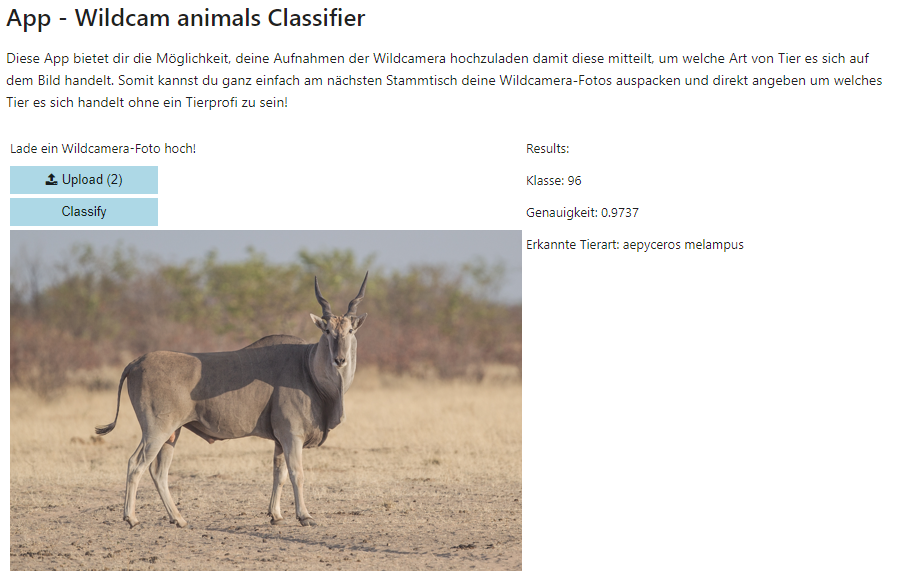

# Quellen
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative